### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import sys
sys.path.insert(0, '../scripts')
from utils import load_data, add_significance_bracket, get_all_interactions, get_interaction_length
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

### Read the data

In [2]:
fp = "../data/DANTE_Pilot_October 13, 2025_21.48.csv"
df = pd.read_csv(fp)
df = df.drop(index=[0,1])

get_all_interactions(df)

# remove internal test cases
df = df[df['participantId'] != ""]

# remove unfinished cases
df = df[df['Finished']=="True"]

# remove cases with no summary
df = df.dropna(subset=['summary', 'llm_response_1'])

# remove certain participants (HTTP and DOM errors with erroneous interactions)
error = ["6B5DC61D3F1A4FD59884E09A7390D115", "9C157F56FEEC4F22BAFEEC11763B9759", "F6586134F687435A9064E1C721EBC99F", "AF09ECC56B13406EAA4D174850B78291", "F28F21C7F66946B785FCCA3E4AEB26B2"]
duplicate_ip = ['3E8D695768544BFAAB256B25B286BE36', '2C25201441924CD69CFB850F9E0C25B7', 'ADE33812DFEE4679855302BB37ABFF84']
dnf = ['498B2C7CFDC6421A8DE46C96D56EFBB2', '57A3377A53CD49C3A03640AC86E08698', '6AEA21E0CC19480D95EF78972E41A441']
df = df[df['participantId'].apply(lambda x: x not in error+duplicate_ip+dnf)]

# Convo satisfaction to numeric
str_to_num = {"Strongly disagree": 1, "Somewhat disagree": 2, "Neither agree nor disagree": 3, "Somewhat agree": 4, "Strongly agree": 5}

for col in ['satis1', 'satis2']:
    df[col] = df[col].map(str_to_num)

# Treatment labels to more readable format
df['treatment'] = df['treatment'].apply(lambda x: f"{x.split('_')[0].capitalize()} {x.split('_')[1].capitalize()}")

# Average satisfaction
df['satis_avg'] = (df['satis1'] + df['satis2']) / 2

# Agree vs Disagree
df['agree_disagree'] = "Agree"
df.loc[df['treatment'].apply(lambda x: "Disagree" in x), 'agree_disagree'] = "Disagree"

# Ingroup vs Outgroup
df['ingroup_outgroup'] = "Ingroup"
df.loc[df['treatment'].apply(lambda x: "Outgroup" in x), 'ingroup_outgroup'] = "Outgroup"

### Analyze

In [3]:
df = get_interaction_length(df)

df.rename(columns={'initial_opinion_length': 'user_response_length_1'}, inplace=True)

In [4]:
for i in range(1, 6):
    for counterpart in ['user', 'llm']:
        col = f'{counterpart}_response_{i}'
        df.loc[~df[col].isna(), f"{counterpart}_response_length_{i}"] = df.loc[~df[col].isna(), col].apply(lambda x: len(x.split(" ")))

/tmp/ipykernel_226918/3834524504.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[~df[col].isna(), f"{counterpart}_response_length_{i}"] = df.loc[~df[col].isna(), col].apply(lambda x: len(x.split(" ")))


In [5]:
def bootstrap_length(df):
    np.random.seed(42)
    n_iterations = 1000
    user_means = {i: [] for i in range(1, 6)}
    llm_means = {i: [] for i in range(1, 6)}
    for i in range(1, 6):
        # Get only non-NaN values for this turn
        df_turn = df.dropna(subset=[f'user_response_length_{i}', f'llm_response_length_{i}'])
        for _ in range(n_iterations):
            sample = df_turn.sample(n=min(500, len(df_turn)), replace=True)
            user_means[i].append(sample[f'user_response_length_{i}'].mean())
            llm_means[i].append(sample[f'llm_response_length_{i}'].mean())
    user_ci = {i: np.percentile(user_means[i], [2.5, 50, 97.5]) for i in range(1, 6)}
    llm_ci = {i: np.percentile(llm_means[i], [2.5, 50, 97.5]) for i in range(1, 6)}
    return user_ci, llm_ci

In [6]:
user_ci, llm_ci = {}, {}
treatments = ["Ingroup Agree", "Ingroup Disagree", "Outgroup Agree", "Outgroup Disagree"]
for treatment in treatments:
    tmp_user, tmp_llm = bootstrap_length(df[(df['treatment'] == treatment)])
    user_ci[treatment] = tmp_user
    llm_ci[treatment] = tmp_llm

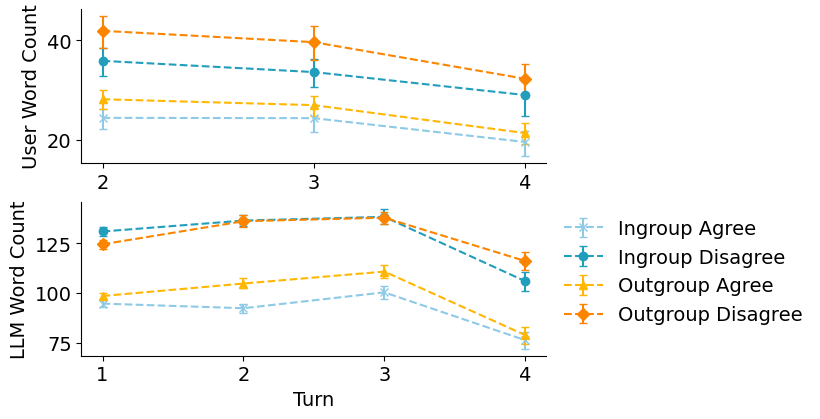

In [7]:
fig, axs = plt.subplots(2,1, figsize=(6, 4.5))
colors = ["#8ecae6", "#219ebc", "#ffb703", "#fb8500"]
markers = ["x", "o", "^", "D"]
for row, ax, ci, group in zip([0,1], axs, [user_ci, llm_ci], ["User", "LLM"]):
    for treatment, color, marker in zip(treatments, colors, markers):
        ci_treatment = ci[treatment]
        # vals = [*ci_treatment.values()]
        # x = [1,2,3,4,5]
        if row == 1:
            vals = [*ci_treatment.values()][:-1]
            x = [1,2,3,4]
        else:
            vals = [*ci_treatment.values()][1:-1]
            x = [2,3,4]
        y = np.array([v[1] for v in vals])
        yerr = np.array([[v[2]-v[1], v[1]-v[0]] for v in vals]).T  # Transpose to get shape (2, 5)

        ax.errorbar(x = x,
                    y = y,
                    yerr = yerr,
                    markersize=6, capsize=3, label=treatment, linestyle='--', color=color, marker=marker)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(x)
    ax.set_ylabel(f"{group} Word Count")

ax.legend(frameon=False,bbox_to_anchor=(1,1))
ax.set_xlabel("Turn")
plt.subplots_adjust(hspace=0.25)

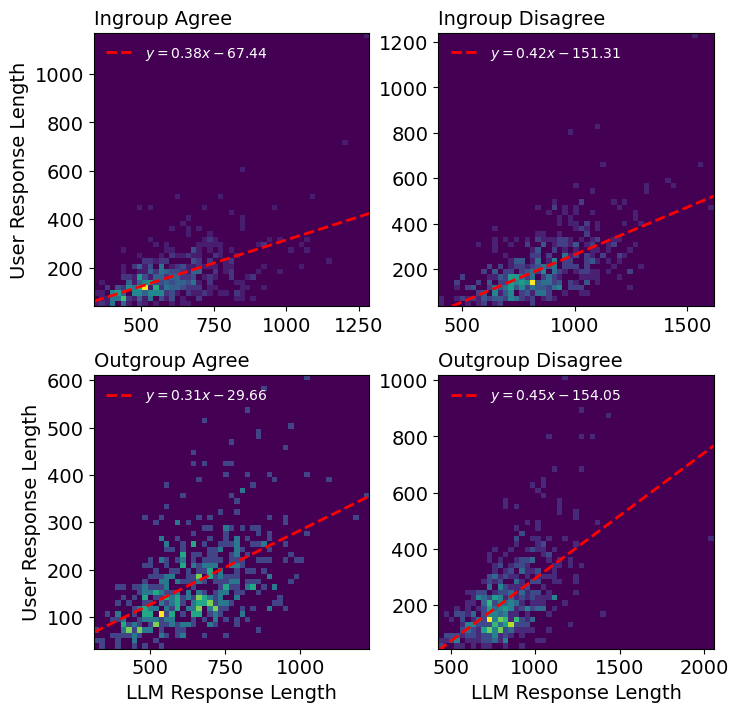

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for ax, treatment in zip(axs.flatten(), treatments):
    treatment_df = df[df['treatment'] == treatment]
    ax.set_title(treatment, loc='left', fontsize=14)
    
    # Create 2D histogram
    ax.hist2d(treatment_df[f'avg_llm_response_length'], treatment_df[f'avg_user_response_length'], bins=51, cmap='viridis')
    
    # Add regression line
    # Filter out NaN values
    valid_data = treatment_df[[f'avg_llm_response_length', f'avg_user_response_length']].dropna()
    if len(valid_data) > 1:
        x_data = valid_data[f'avg_llm_response_length']
        y_data = valid_data[f'avg_user_response_length']
        
        # Calculate regression line
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        
        # Plot regression line
        x_line = np.linspace(x_data.min(), x_data.max(), 100)
        label=f'$y={z[0]:.2f}x{z[1]:.2f}$'
        ax.plot(x_line, p(x_line), "r--", linewidth=2, label=label)
        ax.legend(loc='upper left', fontsize=10, frameon=False, labelcolor='white')

axs[0, 0].set_ylabel('User Response Length')
axs[1, 0].set_ylabel('User Response Length')

axs[1, 0].set_xlabel('LLM Response Length')
axs[1, 1].set_xlabel('LLM Response Length')

plt.subplots_adjust(wspace=0.25, hspace=0.25)